In [2]:
from __future__ import print_function
import os
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
# from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
import cv2
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm
from utils.timer import Timer
import matplotlib.pyplot as plt

In [3]:
FIX_AFTER_MODEL = False

In [4]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [5]:
torch.set_grad_enabled(False)
cfg = {
    'name': 'mobilenet0.25',
    'min_sizes': [[16, 32], [64, 128], [256, 512]],
    'steps': [8, 16, 32],
    'variance': [0.1, 0.2],
    'clip': False,
    'loc_weight': 2.0,
    'gpu_train': True,
    'batch_size': 32,
    'ngpu': 1,
    'epoch': 250,
    'decay1': 190,
    'decay2': 220,
    'image_size': 640,
    'pretrain': False,
    'return_layers': {'stage1': 1, 'stage2': 2, 'stage3': 3},
    'in_channel': 32,
    'out_channel': 64
}

# net and model
net = RetinaFace(cfg=cfg, phase = 'test')
net = load_model(net, "weights/mobilenet0.25_Final.pth", True)
net.eval()
print('Finished loading model!')
print(net)
cudnn.benchmark = True
device = torch.device("cpu" if True else "cuda")
net = net.to(device)

NumANCHOR  2
Loading pretrained model from weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (stage1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, 

/tmp/ipykernel_23665/1036366865.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)

In [6]:
def detect_faces(img_raw,vis_thres=0.9):
    if(type(img_raw)==str):
        img_raw = cv2.imread(img_raw, cv2.IMREAD_COLOR)
    img = np.float32(img_raw)
    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)
    _t = {'forward_pass': Timer(), 'misc': Timer()}
    resize = 1

    _t['forward_pass'].tic()
    loc, conf, landms = net(img)  # forward pass
    _t['forward_pass'].toc()
    _t['misc'].tic()
    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()
    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                            img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                            img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > 0.02)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMS
    # order = scores.argsort()[::-1][:args.top_k]
    order = scores.argsort()[::-1]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, 0.4)

    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    # dets = dets[:args.keep_top_k, :]
    # landms = landms[:args.keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)
    facess  = []
    for b in dets:
        if b[4] < vis_thres:
            continue
        xs = b[4]
        b = list(map(int, b))
        b.append(xs)
        facess.append(b)

    return facess

In [7]:
import cv2


def find_darkest_point_in_box_center(image, x, y, w, h):
    # Đọc ảnh
    # image = cv2.imread(image_path)

    # Chuyển ảnh sang thang độ xám
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Lấy kích thước ảnh
    height, width = gray_image.shape

    # Xác định tọa độ của góc trên trái và dưới phải dựa trên tâm (x, y)
    x1 = max(0, int(x - w / 2))
    y1 = max(0, int(y - h / 2))
    x2 = min(width, int(x + w / 2))
    y2 = min(height, int(y + h / 2))

    # Cắt vùng box ra khỏi ảnh
    box = gray_image[y1:y2, x1:x2]

    # Tìm tọa độ của điểm tối nhất trong box
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(box)

    # Tính lại tọa độ điểm tối nhất dựa trên ảnh gốc
    darkest_point = (min_loc[0] + x1, min_loc[1] + y1)

    return darkest_point

def draw_faces_landmarks(image_path, faces_data, output_image_path=None):
    image = cv2.imread(image_path)
    for  face_data in faces_data:
        x1, y1, x2, y2 =face_data[0:4]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box
        # S = abs((x1-x2)*(y2-y1))
        # 1/4 1/8

        if(FIX_AFTER_MODEL):
            face_data[5],face_data[6] = find_darkest_point_in_box_center(image,face_data[5],face_data[6],((x2-x1)/4),((y2-y1))/8)
            face_data[7],face_data[8] = find_darkest_point_in_box_center(image,face_data[7],face_data[8],((x2-x1)/4),((y2-y1))/8)
        for item in range(5,15,2):
            cv2.circle(image, (int(face_data[item]), int(face_data[item+1])), 1, (0, 0, 255), 4)  # Red dots
        
    # Save the image with bounding boxes and landmarks
    if(output_image_path):
        cv2.imwrite(output_image_path, image)
        print(f"Image saved to {output_image_path}")
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Tắt hiển thị trục
        plt.tight_layout()
        plt.show()

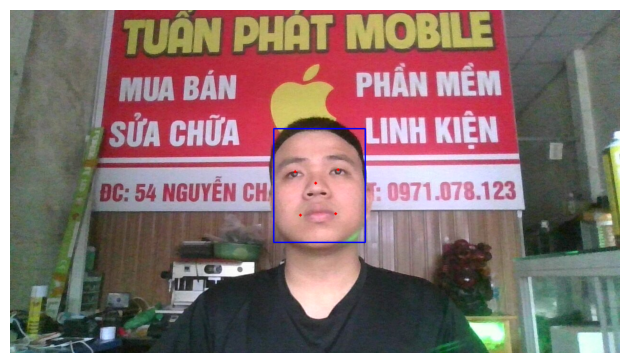

Face Orientation: ('Up', 'Center')


In [34]:
image_path = "/home/four/Pictures/Webcam/thang.jpg"
# img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
facess = detect_faces(image_path)
# print(len(facess))
# print(facess)
draw_faces_landmarks(image_path,facess)
face  = facess[0]
orientation = calculate_face_orientation(face[0:4], face[5:15])
print("Face Orientation:", orientation)

In [6]:
import numpy as np
import math

def calculate_face_orientation_improved(box, landmarks):
    # Unpack landmarks
    left_eye = (landmarks[0], landmarks[1])      # mắt trái
    right_eye = (landmarks[2], landmarks[3])     # mắt phải
    nose = (landmarks[4], landmarks[5])          # mũi
    left_mouth = (landmarks[6], landmarks[7])    # mép miệng trái
    right_mouth = (landmarks[8], landmarks[9])   # mép miệng phải

    # Calculate centers
    eye_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)
    mouth_center = ((left_mouth[0] + right_mouth[0]) / 2, (left_mouth[1] + right_mouth[1]) / 2)

    # Calculate pitch
    pitch = (nose[1] - eye_center[1]) / (mouth_center[1] - eye_center[1])

    # Calculate yaw
    yaw = nose[0] - mouth_center[0]

    # Calculate roll (angle between the eyes)
    delta_x = right_eye[0] - left_eye[0]
    delta_y = right_eye[1] - left_eye[1]
    roll = math.atan2(delta_y, delta_x)  # Roll in radians
    roll = math.degrees(roll)            # Convert to degrees

    return {
        "pitch": pitch,
        "yaw": yaw,
        "roll": roll
    }

# Example data
box = [497, 206, 708, 473]
landmarks = [554, 324, 649, 316, 605, 390, 569, 418, 644, 411]

# Calculate face orientation
orientation = calculate_face_orientation(box, landmarks)
print("Face Orientation:", orientation)


NameError: name 'calculate_face_orientation' is not defined

In [7]:
def calculate_face_orientation(box, landmarks):
    # Unpack landmarks
    left_eye = (landmarks[0], landmarks[1])      # mắt trái
    right_eye = (landmarks[2], landmarks[3])     # mắt phải
    nose = (landmarks[4], landmarks[5])          # mũi
    left_mouth = (landmarks[6], landmarks[7])    # mép miệng trái
    right_mouth = (landmarks[8], landmarks[9])   # mép miệng phải

    # Calculate centers
    eye_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)
    mouth_center = ((left_mouth[0] + right_mouth[0]) / 2, (left_mouth[1] + right_mouth[1]) / 2)

    # Calculate pitch
    pitch = (nose[1] - eye_center[1]) / (mouth_center[1] - eye_center[1])

    # Calculate yaw
    yaw = nose[0] - mouth_center[0]
    print(pitch,yaw)
    # Translate orientation to text
    # pitch_text = "Up" if pitch < -0.1 else "Down" if pitch > 0.1 else "Neutral"
    pitch_text = "Up" if pitch <0.30 else "Down" if pitch >0.70 else "Neutral"
    yaw_text = "Left" if yaw < -10 else "Right" if yaw > 10 else "Center"

    return pitch_text, yaw_text

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    # faces = face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))
    faces = detect_faces(frame)


    for face in faces:
        # x, y, w, h = face
        x, y, w, h  = face[0:4]
        landmarks = face[5:15]

        # Draw face bounding box
        # cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Fake landmarks (replace with real detector if available)
        # landmarks = fake_landmarks(face)

        # Draw landmarks
        # for i in range(0, len(landmarks), 2):
        #     cv2.circle(frame, (landmarks[i], landmarks[i+1]), 3, (0, 255, 0), -1)

        # Calculate face orientation
        pitch_text, yaw_text = calculate_face_orientation(None, landmarks)

        # Display orientation
        cv2.putText(frame, f"Pitch: {pitch_text}", (x, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        cv2.putText(frame, f"Yaw: {yaw_text}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    # Show the frame
    cv2.imshow("Face Orientation", frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0.5879629629629629 7.0
0.5277777777777778 1.5
0.5963302752293578 6.0
0.5833333333333334 1.0
0.5852534562211982 7.0
0.5833333333333334 1.5
0.5833333333333334 7.0
0.5714285714285714 0.5
0.5720930232558139 8.0
0.5526315789473685 1.5
0.5833333333333334 8.0
0.5428571428571428 2.5
0.5779816513761468 8.5
0.5555555555555556 2.5
0.5779816513761468 8.0
0.5277777777777778 2.5
0.5906976744186047 8.0
0.5294117647058824 2.5
0.5833333333333334 7.5
0.5294117647058824 3.0
0.5833333333333334 7.5
0.5428571428571428 2.5
0.5887850467289719 7.0
0.5 2.5
0.5806451612903226 8.5
0.5294117647058824 2.5
0.5813953488372093 7.5
0.5555555555555556 2.5
0.5833333333333334 8.5
0.5428571428571428 2.5
0.5779816513761468 8.0
0.5428571428571428 2.5
0.5825688073394495 8.0
0.5428571428571428 2.5
0.576036866359447 7.0
0.5428571428571428 2.5
0.5596330275229358 8.5
0.5428571428571428 2.5
0.5707762557077626 7.5
0.5555555555555556 2.5
0.5898617511520737 6.0
0.5142857142857142 1.5
0.5879629629629629 6.5
0.5555555555555556 1.5
0.58

In [13]:
import cv2

def calculate_face_orientation(box, landmarks):
    # Unpack landmarks
    left_eye = (landmarks[0], landmarks[1])      # mắt trái
    right_eye = (landmarks[2], landmarks[3])     # mắt phải
    nose = (landmarks[4], landmarks[5])          # mũi
    left_mouth = (landmarks[6], landmarks[7])    # mép miệng trái
    right_mouth = (landmarks[8], landmarks[9])   # mép miệng phải

    # Calculate centers
    eye_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)
    mouth_center = ((left_mouth[0] + right_mouth[0]) / 2, (left_mouth[1] + right_mouth[1]) / 2)

    # Calculate pitch
    pitch = (nose[1] - eye_center[1]) / (mouth_center[1] - eye_center[1])

    # Calculate yaw
    yaw = nose[0] - mouth_center[0]

    return pitch, yaw

def save_selected_frames(frames_data, output_names):
    for name, key in zip(output_names, frames_data.keys()):
        if frames_data[key]["frame"] is not None:
            cv2.imwrite("/home/four/Code/DATA/face/Nhan_face_"+name, frames_data[key]["frame"])
            print(f"Saved {key} frame as {name}")

# Video file path
video_path = "/home/four/Code/DATA/Nhan_face.mp4"  # Đặt đường dẫn tới video của bạn
cap = cv2.VideoCapture(video_path)

# Generalized ranges
center_range = {
    "left": {"yaw": [-30, -20], "pitch": [0.30, 0.70]},
    "right": {"yaw": [20, 30], "pitch": [0.30, 0.70]},
    "center": {"yaw": [-5, 10], "pitch": [0.40, 0.70]},
    "up": {"yaw": [-10, 10], "pitch": [0.0, 0.40]},
    "down": {"yaw": [-10, 10], "pitch": [0.70, 1.0]},
}

# Variables to store selected frames
frames_data = {
    "left": {"frame": None, "score": float("inf")},
    "right": {"frame": None, "score": float("inf")},
    "center": {"frame": None, "score": float("inf")},
    "up": {"frame": None, "score": float("inf")},
    "down": {"frame": None, "score": float("inf")},
}

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces (replace with your actual face detection method)
    faces = detect_faces(frame)  # Bạn cần định nghĩa detect_faces nếu chưa có

    for face in faces:
        x, y, w, h = face[0:4]
        landmarks = face[5:15]

        # Draw landmarks
        # for i in range(0, len(landmarks), 2):
        #     cv2.circle(frame, (landmarks[i], landmarks[i+1]), 3, (0, 255, 0), -1)

        # Calculate face orientation
        pitch, yaw = calculate_face_orientation(None, landmarks)

        for key, range_condition in center_range.items():
            yaw_range = range_condition["yaw"]
            pitch_range = range_condition["pitch"]

            if yaw_range[0] <= yaw <= yaw_range[1] and pitch_range[0] <= pitch <= pitch_range[1]:
                # Calculate score
                yaw_center = (yaw_range[0] + yaw_range[1]) / 2
                pitch_center = (pitch_range[0] + pitch_range[1]) / 2
                score = abs(yaw - yaw_center) + abs(pitch - pitch_center)

                if score < frames_data[key]["score"]:
                    frames_data[key] = {"frame": frame.copy(), "score": score}

        # Display orientation
        print(pitch)
        pitch_text = "Up" if pitch < 0.30 else "Down" if pitch > 0.70 else "Neutral"
        yaw_text = "Left" if yaw < -20 else "Right" if yaw > 20 else "Center"

        cv2.putText(frame, f"Pitch: {pitch_text}", (x, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        cv2.putText(frame, f"Yaw: {yaw_text}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    # Show the frame
    cv2.imshow("Face Orientation", frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Final save (in case the loop finishes naturally)
save_selected_frames(frames_data, ["left.jpg", "right.jpg", "center.jpg", "up.jpg","down.jpg"])


0.48533333333333334
0.48404255319148937
0.48404255319148937
0.4867021276595745
0.4827586206896552
0.4854111405835544
0.4868421052631579
0.48812664907651715
0.48548812664907653
0.48677248677248675
0.4854111405835544
0.48404255319148937
0.48812664907651715
0.4973404255319149
0.48936170212765956
0.44533333333333336
0.42487046632124353
0.46194225721784776
0.4691689008042895
0.48579545454545453
0.4750733137829912
0.47335423197492166
0.5
0.4791666666666667
0.46757679180887374
0.4983164983164983
0.46440677966101696
0.5469255663430421
0.5440251572327044
0.49140893470790376
0.46075085324232085
0.5339233038348082
0.4984025559105431
0.5727002967359051
0.43944636678200694
0.4548611111111111
0.5068493150684932
0.4391025641025641
0.4740484429065744
0.4430379746835443
0.4416403785488959
0.4555160142348754
0.4634146341463415
0.4647887323943662
0.47719298245614034
0.4788732394366197
0.47183098591549294
0.47202797202797203
0.47038327526132406
0.4612676056338028
0.4628975265017668
0.4657039711191336
0.44

WEB

In [ ]:
import cv2
import numpy as np
import base64
from fastapi import FastAPI, WebSocket
from fastapi.responses import HTMLResponse

app = FastAPI()

# Function to calculate face orientation
def calculate_face_orientation(box, landmarks):
    left_eye = (landmarks[0], landmarks[1])
    right_eye = (landmarks[2], landmarks[3])
    nose = (landmarks[4], landmarks[5])
    left_mouth = (landmarks[6], landmarks[7])
    right_mouth = (landmarks[8], landmarks[9])

    # Calculate centers
    eye_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)
    mouth_center = ((left_mouth[0] + right_mouth[0]) / 2, (left_mouth[1] + right_mouth[1]) / 2)

    # Calculate pitch and yaw
    pitch = (nose[1] - eye_center[1]) / (mouth_center[1] - eye_center[1])
    yaw = nose[0] - mouth_center[0]

    return pitch, yaw

# Mock face detection function
def detect_faces(frame):
    # Replace with your actual face detector
    # Mock: Return a single face with dummy landmarks for testing
    height, width, _ = frame.shape
    box = [int(width * 0.3), int(height * 0.3), int(width * 0.7), int(height * 0.7)]
    landmarks = [
        int(width * 0.4), int(height * 0.35),  # Left eye
        int(width * 0.6), int(height * 0.35),  # Right eye
        int(width * 0.5), int(height * 0.5),   # Nose
        int(width * 0.45), int(height * 0.65), # Left mouth
        int(width * 0.55), int(height * 0.65)  # Right mouth
    ]
    return [box + landmarks]

# Process a single frame for face orientation
def process_frame(frame_bytes):
    # Decode base64-encoded image
    nparr = np.frombuffer(base64.b64decode(frame_bytes), np.uint8)
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Detect faces and calculate orientations
    faces = detect_faces(frame)
    for face in faces:
        box = face[:4]
        landmarks = face[4:]

        # Calculate orientation
        pitch, yaw = calculate_face_orientation(box, landmarks)

        # Determine text for pitch and yaw
        pitch_text = "Up" if pitch < 0.30 else "Down" if pitch > 0.70 else "Neutral"
        yaw_text = "Left" if yaw < -10 else "Right" if yaw > 10 else "Center"

        # Draw face box and landmarks
        x, y, x2, y2 = box
        cv2.rectangle(frame, (x, y), (x2, y2), (255, 0, 0), 2)
        for i in range(0, len(landmarks), 2):
            cv2.circle(frame, (landmarks[i], landmarks[i+1]), 3, (0, 255, 0), -1)

        # Display orientation on frame
        cv2.putText(frame, f"Pitch: {pitch_text}", (x, y - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        cv2.putText(frame, f"Yaw: {yaw_text}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    # Encode frame back to base64 for return
    _, buffer = cv2.imencode('.jpg', frame)
    frame_base64 = base64.b64encode(buffer).decode('utf-8')

    return frame_base64

@app.get("/")
def get_home():
    return HTMLResponse("""
    <!DOCTYPE html>
    <html>
    <body>
    <h1>WebSocket Video Stream with Face Orientation</h1>
    <video id="video" autoplay muted style="width: 50%;"></video>
    <canvas id="canvas" style="display: none;"></canvas>
    <img id="output" style="border: 2px solid black;">
    <script>
    const ws = new WebSocket("ws://localhost:8000/ws");
    const video = document.getElementById('video');
    const canvas = document.getElementById('canvas');
    const output = document.getElementById('output');
    const ctx = canvas.getContext('2d');
    
    // Access webcam
    navigator.mediaDevices.getUserMedia({ video: true }).then((stream) => {
        video.srcObject = stream;
    });

    video.addEventListener('play', () => {
        setInterval(() => {
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            ctx.drawImage(video, 0, 0, canvas.width, canvas.height);

            // Send frame to server
            const dataUrl = canvas.toDataURL('image/jpeg');
            const base64Frame = dataUrl.split(',')[1]; // Remove "data:image/jpeg;base64,"
            ws.send(base64Frame);
        }, 100); // Send frame every 100ms
    });

    ws.onmessage = (event) => {
        // Receive processed frame and display
        output.src = `data:image/jpeg;base64,${event.data}`;
    };
    </script>
    </body>
    </html>
    """)

@app.websocket("/ws")
async def websocket_endpoint(websocket: WebSocket):
    await websocket.accept()
    while True:
        try:
            # Receive frame from client
            frame_bytes = await websocket.receive_text()

            # Process frame and send back
            processed_frame = process_frame(frame_bytes)
            await websocket.send_text(processed_frame)
        except Exception as e:
            print(f"Error: {e}")
            break


In [ ]:


import os

os.system("uvicorn app:app --reload")

sh: 1: uvicorn: not found


32512

In [ ]:
import math


def calculate_angle(point1, point2):
    print(point1,point2)
    # Tính độ dốc (slope)
    dy = point2[1] - point1[1]
    dx = point2[0] - point1[0]
    
    # Tránh chia cho 0
    if dx == 0:
        return 90 if dy > 0 else 270  # 90 độ nếu đi lên, 270 độ nếu đi xuống
    
    slope = dy / dx
    
    # Tính góc (tính bằng radian và chuyển sang độ)
    angle_rad = math.atan(slope)
    angle_deg = math.degrees(angle_rad)
    
    # # Điều chỉnh góc về miền từ 0 đến 360 độ
    # if angle_deg < 0:
    #     angle_deg += 360
    
    return angle_deg
from PIL import Image


def rotate_image(image_path, angle):
    # Mở ảnh
    img = Image.open(image_path)
    
    # Xoay ảnh
    rotated_img = img.rotate(angle)
    
    # Lưu ảnh đã xoay
    # rotated_img.save('rotated_image.png',quality=100)
    
    return rotated_img

# Đường dẫn tới ảnh
# image_path = 'path_to_your_image.jpg'

# Xoay ảnh 15 độ
face = facess[0]
rotated_image = rotate_image(image_path, (calculate_angle([face[5],face[6]],[face[7],face[8]])+calculate_angle([face[11],face[12]],[face[13],face[14]]))/2)

# Hiển thị ảnh đã xoay (nếu cần)
rotated_image.show()


NameError: name 'rotate_image' is not defined

In [9]:
print(calculate_angle([face[5],face[6]],[face[7],face[8]]))

[734, 1001] [896, 1027]
9.117862753795789


In [10]:
# rectangle_points = [(face[0], face[1]), (face[0]+face[2], face[1]), (face[0]+face[2], face[1]+face[3]), (face[0],face[1]+face[3])]
x1,y1,x2,y2 = face[0:4]
rectangle_points =[[x1,y1],[x2,y1],[x2,y2],[x1,y2]]
print(rectangle_points)

[[613, 808], [1030, 808], [1030, 1293], [613, 1293]]


In [11]:
import math
import matplotlib.pyplot as plt

def rotate_rectangle(points, angle):
    # Tính tọa độ trung tâm
    center_x = sum(x for x, y in points) / len(points)
    center_y = sum(y for x, y in points) / len(points)

    # Chuyển đổi góc từ độ sang radian
    radian = math.radians(angle)
    
    # Ma trận xoay
    cos_angle = math.cos(radian)
    sin_angle = math.sin(radian)
    
    rotated_points = []
    
    for (x, y) in points:
        # Di chuyển điểm về gốc tọa độ
        x -= center_x
        y -= center_y
        
        # Tính tọa độ mới
        x_new = x * cos_angle - y * sin_angle
        y_new = x * sin_angle + y * cos_angle
        
        # Di chuyển điểm trở lại vị trí cũ
        x_new += center_x
        y_new += center_y
        
        rotated_points.append((x_new, y_new))
    
    return rotated_points



[734, 1001] [896, 1027]
[723, 1156] [850, 1179]
[[613, 808], [1030, 808], [1030, 1293], [613, 1293]]
Tọa độ mới sau khi xoay: [(656.7988378218815, 776.3612993808114), (1067.8476012311935, 846.5604026491255), (986.2011621781185, 1324.6387006191885), (575.1523987688064, 1254.4395973508745)]


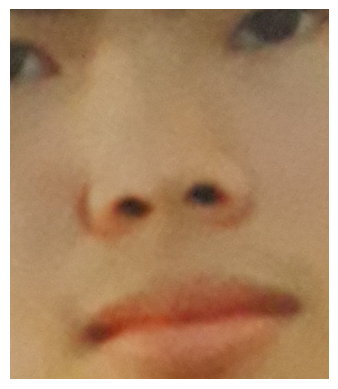

In [12]:
import math

angel_ = (calculate_angle([face[5],face[6]],[face[7],face[8]])+calculate_angle([face[11],face[12]],[face[13],face[14]]))/2

face = facess[0]

# Tọa độ 4 điểm hình chữ nhật (ví dụ)

x1,y1,x2,y2 = face[0:4]
rectangle_points =[[x1,y1],[x2,y1],[x2,y2],[x1,y2]]
print(rectangle_points)
# Góc xoay (độ)
angle_of_rotation = angel_

# Tính tọa độ mới sau khi xoay
new_points = rotate_rectangle(rectangle_points, angle_of_rotation)
# print()
print("Tọa độ mới sau khi xoay:", new_points)

def cut_rotated_rectangle(image_path, points):
    # Mở ảnh
    image = cv2.imread(image_path)

    # Chuyển đổi danh sách điểm thành mảng NumPy
    points = np.array(points, dtype='float32')

    # Xác định tọa độ cho hình chữ nhật mới
    width = int(max(np.linalg.norm(points[0] - points[1]), np.linalg.norm(points[2] - points[3])))
    height = int(max(np.linalg.norm(points[0] - points[3]), np.linalg.norm(points[1] - points[2])))

    # Điểm góc cho hình chữ nhật đã cắt
    dest_points = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype='float32')

    # Tính ma trận biến đổi
    M = cv2.getPerspectiveTransform(points, dest_points)

    # Cắt hình
    cropped_image = cv2.warpPerspective(image, M, (width, height))

    return cropped_image


cropped_image = cut_rotated_rectangle(image_path, new_points)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
# cv2.imwrite("out.jpg",cropped_image)
plt.axis(False)
plt.show()



In [13]:
import cv2
import numpy as np

# Hàm xoay ảnh mà không cắt góc và giữ nguyên sự trong suốt
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Tính toán kích thước khung mới để chứa toàn bộ ảnh sau khi xoay
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    # Tính kích thước mới của khung sau khi xoay
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Điều chỉnh ma trận xoay để căn giữa ảnh
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    # Xoay ảnh, bao gồm cả kênh alpha để giữ sự trong suốt
    rotated = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
    
    return rotated

def glass_grafting(image2,image1,angel_):

# Đọc ảnh PNG (bao gồm kênh alpha)
    # image1 = cv2.imread('data/glasses/glasses_01.png', cv2.IMREAD_UNCHANGED)  # Sử dụng IMREAD_UNCHANGED để giữ kênh alpha
    # image2 = cv2.imread('c:/Users/four/Downloads/Untitled.jpg')

    # Xoay ảnh 1 10 độ
    rotated_image1 = rotate_image(image1, angel_)

    # Đảm bảo ảnh nền (image2) có cùng kênh alpha
    if image2.shape[2] == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2BGRA)

    # Vị trí để chèn (có thể điều chỉnh)
    (x_offset, y_offset) = (50, 50)

    # Giới hạn kích thước của vùng chèn sao cho không vượt quá kích thước của ảnh nền
    y1, y2 = max(0, y_offset), min(image2.shape[0], y_offset + rotated_image1.shape[0])
    x1, x2 = max(0, x_offset), min(image2.shape[1], x_offset + rotated_image1.shape[1])

    # Giới hạn kích thước ảnh đã xoay để phù hợp với vùng chèn
    rotated_crop = rotated_image1[0:(y2 - y1), 0:(x2 - x1)]

    # Tạo vùng chứa để giữ sự trong suốt
    alpha_rotated = rotated_crop[:, :, 3] / 255.0  # Lấy kênh alpha của ảnh đã xoay
    alpha_background = 1.0 - alpha_rotated

    # Chèn ảnh vào nền với alpha
    for c in range(0, 3):  # Chèn các kênh RGB với alpha
        image2[y1:y2, x1:x2, c] = (alpha_rotated * rotated_crop[:, :, c] +
                                alpha_background * image2[y1:y2, x1:x2, c])

    return image2
# Lưu kết quả với định dạng PNG để giữ sự trong suốt
# cv2.imwrite('output.png', image2)

# # Hiển thị ảnh kết quả
# cv2.imshow('Output Image', image2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [14]:

# Các cấu hình cần thiết như 'cfg', 'net', và 'device' cần được định nghĩa từ trước
import math
glass1 = cv2.imread("data/glasses/glasses_01.png")
w_1,h_1 = glass1.shape[:2] 
point_glass1 = [[210,290],[590,290]]

def detect_from_webcam():
    cap = cv2.VideoCapture(0)  # Mở webcam

    while True:
        ret, img_raw = cap.read()  # Đọc từng khung hình từ webcam
        if not ret:
            break
        data_faces = detect_faces(img_raw)
        for b in data_faces:
            cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
            cx = b[0]
            cy = b[1] + 12
            cv2.putText(img_raw, f"{(int(b[15]*10000))/10000}", (cx, cy),
                        cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

            # Vẽ các landmarks
            if(FIX_AFTER_MODEL):
                x1, y1, x2, y2 =b[0:4]
                b[5],b[6] = find_darkest_point_in_box_center(img_raw,b[5],b[6],((x2-x1)/4),((y2-y1))/8)
                b[7],b[8] = find_darkest_point_in_box_center(img_raw,b[7],b[8],((x2-x1)/4),((y2-y1))/8)

            cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
            cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)

            d_eyes = math.sqrt((b[7]-b[5])*(b[7]-b[5])+(b[8]-b[6])*(b[8]-b[6]))
            resized_glass1 = cv2.resize(glass1, (int(w_1*d_eyes/(point_glass1[0][1] - point_glass1[0][0])), int(h_1*d_eyes/(point_glass1[0][1] - point_glass1[0][0]))))
            angle_ = (calculate_angle([b[5],b[6]],[b[7],b[8]])+calculate_angle([b[11],b[12]],[b[13],b[14]]))/2
            result = glass_grafting(img_raw,resized_glass1,angel_)
            # rotated_overlay = rotate_image2(resized_glass1,angle_)
            # result = overlay_image2(img_raw, rotated_overlay, 50, 50)



            # cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
            # cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
            # cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)

        # Hiển thị khung hình
        cv2.imshow('Webcam Detection', result)
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Chạy hàm phát hiện từ webcam
if True: detect_from_webcam()


[313, 427] [393, 439]
[317, 479] [374, 488]


IndexError: index 3 is out of bounds for axis 2 with size 3